# Project milestone 4
# Detection of housing-health relationship


The aim of this project is to estimate the relation between housing quality and health status of a person. The project is an observational study based on a survey made by Mexican National Institute of Statistics and Geography in 2017 ([National Household Survey 2017](https://en.www.inegi.org.mx/programas/enh/2017/#Microdata)). The health variables reported for each person will be used to define a single health variable which will be a score for each person's health status. We aim to use machine learning methods to do the classification and we will use regression models to predict this health score from the housing variables. Matching will be used to weed out the possible covariates. The motivation is to estimate the most important parameters of housing quality so that we can propose most cost-effective solutions that would increase the quality of health. The original paper is based on the analysis of influence of concrete floors on health quality, while here we would investigate some other parameters such as material used for building and whether there is a toilet or not in the household.

# Step 1: Data preprocessing

In [19]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In this section, we load the translated headers (from spanish to english) and the datasets. We verified that the number of entries correspond to the [File Descriptor FD](https://en.www.inegi.org.mx/app/biblioteca/ficha.html?upc=702825101725) provided by INEGI. Note that we will use the word *person* instead of *member* as a translation to *persona* because we consider it is a better translation.

In [3]:
# Load the translated headers
vivienda_header_trans = pd.read_csv('./data/translated_house.txt', squeeze=True, header =None)
hogar_header_trans = pd.read_csv('./data/translated_household.txt', squeeze=True, header=None)
persona_header_trans = pd.read_csv('./data/translated_person.txt', squeeze=True, header=None)

# Load the datasets with the translated headers
data_housing = pd.read_csv('./data/vivienda.csv', skiprows=1, names=vivienda_header_trans, low_memory=False)
data_household = pd.read_csv('./data/hogar.csv', skiprows=1, names=hogar_header_trans, low_memory=False)
data_person = pd.read_csv('./data/persona.csv', skiprows=1, names=persona_header_trans, low_memory=False)

print('vivienda.csv shape: {}'.format(data_housing.shape))
print('hogar.csv shape: {}'.format(data_household.shape))
print('persona.csv shape: {}'.format(data_person.shape))

vivienda.csv shape: (56680, 110)
hogar.csv shape: (57519, 13)
persona.csv shape: (208140, 58)


The [File Descriptor FD](https://en.www.inegi.org.mx/app/biblioteca/ficha.html?upc=702825101725) tell us that for each housing, there can be more that one households and for each household, there can be more than one person. We use these the information to merge first `data_housing` into `data_household` and then into `data_person`.

In [4]:
# Merge the data on the 'house_identifier column'
data_household_all = data_household.merge(data_housing, on='housing_identifier')
data_person_all = data_person.merge(data_household_all, on=['housing_identifier', 'household_identifier'])

print('data_person_all shape: {}'.format(data_person_all.shape))
data_person_all.sample(10)

data_person_all shape: (208140, 178)


,housing_identifier,household_identifier,person_identifier,age,birthday,birth_month,sex,relationship,school_attendance,school_type,...,pay_tv_service_availability,availability_of_own_car,total_households_in_the_dwelling,geographic_location,basic_geostatistical_area,location_size,socioeconomic,sample_design_stratum,primary_sampling_unit,expansion_factor
85716,1406566105,2,2,30,09,04,2,2,2,,...,2,1,2,141010000,000-0,1,2,134,3567,1162
115846,1860460248,1,5,4,26,08,2,3,1,1,...,2,2,1,180200000,000-0,4,2,182,4654,192
29567,506266207,1,7,8,20,10,2,3,1,1,...,1,2,1,50280000,000-0,2,2,42,1381,532
91452,1505621157,1,2,51,10,01,2,2,2,,...,2,2,1,150330000,000-0,1,2,146,3780,2518
52632,909109056,1,3,6,22,07,1,3,1,1,...,2,1,1,90070000,000-0,1,2,80,2333,1364
61363,1060089001,1,2,36,14,06,2,2,2,,...,1,1,1,100160000,000-0,4,2,88,2818,251
94692,1523578059,1,5,23,06,12,2,3,2,,...,1,1,1,151090000,000-0,2,2,149,3960,2300
124396,2002422059,1,3,14,19,06,1,3,1,1,...,2,2,1,201150000,000-0,3,2,210,5068,578
153919,2460455183,1,4,1,20,04,1,3,,,...,1,2,1,240210000,000-0,4,1,254,6164,366
87688,1412206021,1,2,39,11,12,2,2,2,,...,2,2,1,141080000,000-0,2,2,128,3654,1001


# Step 2: Exploratory Data Analysis
## Health variables
We chose as our health variables the following ones. We drop other health related variables because they were not correctly filled and most of the answer were empty (e.g. `['walking_apparatus', 'intensity_of_nervousness', 'intensity_of_depression', 'pain_intensity', 'intensity_of_fatigue', 'tired_time']`). However the information is still present in the chosen ones.

In [5]:
health_var = ['wear_glasses', 'difficulty_seeing', 'wear_a_hearing_aid','difficulty_hearing',
                'difficulty_hearing_without_noise','difficulty_hearing_with_noise', 'dificulty_to_walk',
                'use_a_walking_device', 'difficulty_walking_100_m', 'difficulty_walking_500_m',
                'difficulty_climbing_12_steps_', 'difficulty_remembering','frequency_of_nervousness',
                'medication_for_nervousness', 'frequency_of_depression', 'antidepressant_medications',
                'frequency_of_pain', 'fatigue_frequency']

## Cleaning and guidelines
Besides cleaning the data (e.g. replacing empty values), we will change the labels of the variables according to the following criteria in order to ensure consistency with health and have better properties for the regression.
* 0 - when the variable suggest a healthy person.
* 1 or greater - when the variable suggest a health issue (in increasing order).
* nan - when there is no answer.


In [6]:
# Cleaning
data_person_all = data_person_all.replace(' ', np.nan)
data_person_all = data_person_all.replace('&', np.nan)
data_person_all = data_person_all.replace('9', np.nan)

We drop all the rows where there is not complete information of the health variables since we lost around 14% of the data but don't do any assumption.

In [7]:
# Drop nan rows for the health_var (i.e. work only with rows with complete information)
data_person_all = data_person_all.dropna(subset=health_var)
data_person_all.shape

(179072, 178)

In [8]:
# Transform from strings to numbers
data_person_all[health_var] = data_person_all[health_var].apply(pd.to_numeric)
data_person_all[health_var].dtypes

wear_glasses                        int64
difficulty_seeing                   int64
wear_a_hearing_aid                  int64
difficulty_hearing                  int64
difficulty_hearing_without_noise    int64
difficulty_hearing_with_noise       int64
dificulty_to_walk                   int64
use_a_walking_device                int64
difficulty_walking_100_m            int64
difficulty_walking_500_m            int64
difficulty_climbing_12_steps_       int64
difficulty_remembering              int64
frequency_of_nervousness            int64
medication_for_nervousness          int64
frequency_of_depression             int64
antidepressant_medications          int64
frequency_of_pain                   int64
fatigue_frequency                   int64
dtype: object

In order to flip the grading of the variables, where the lowest value reflects a health issue, we verify that each column has a maximum value corresponding to the [File Descriptor FD](https://en.www.inegi.org.mx/app/biblioteca/ficha.html?upc=702825101725). This allows us to multiply each column by -1 and substract the maximum of the column.

In [9]:
# Variables where we flip the grading for consistency in the grading.
flipped_var = ['wear_glasses', 'wear_a_hearing_aid', 'use_a_walking_device', 'frequency_of_nervousness',
                'medication_for_nervousness', 'frequency_of_depression', 'antidepressant_medications'] 

# Verify that each column has the correct maximum possible value. 
data_person_all[flipped_var].max(axis=0)

# Substract one from all the columns and flip the grading for the flipped var
data_person_all[health_var] = data_person_all[health_var] - 1
data_person_all[flipped_var] = data_person_all[flipped_var]*-1 + data_person_all[flipped_var].max(axis=0)

display(data_person_all[health_var].max(axis=0))
display(data_person_all[health_var].min(axis=0))

wear_glasses                        1
difficulty_seeing                   3
wear_a_hearing_aid                  1
difficulty_hearing                  2
difficulty_hearing_without_noise    2
difficulty_hearing_with_noise       3
dificulty_to_walk                   3
use_a_walking_device                1
difficulty_walking_100_m            2
difficulty_walking_500_m            3
difficulty_climbing_12_steps_       3
difficulty_remembering              3
frequency_of_nervousness            4
medication_for_nervousness          1
frequency_of_depression             4
antidepressant_medications          1
frequency_of_pain                   3
fatigue_frequency                   3
dtype: int64

wear_glasses                        0
difficulty_seeing                   0
wear_a_hearing_aid                  0
difficulty_hearing                  0
difficulty_hearing_without_noise    0
difficulty_hearing_with_noise       0
dificulty_to_walk                   0
use_a_walking_device                0
difficulty_walking_100_m            0
difficulty_walking_500_m            0
difficulty_climbing_12_steps_       0
difficulty_remembering              0
frequency_of_nervousness            0
medication_for_nervousness          0
frequency_of_depression             0
antidepressant_medications          0
frequency_of_pain                   0
fatigue_frequency                   0
dtype: int64

In [10]:
# See all the ranges
for var in health_var:
    print('{}\t{}'.format(var, data_person_all[var].unique()))

wear_glasses	[1 0]
difficulty_seeing	[0 2 1 3]
wear_a_hearing_aid	[0 1]
difficulty_hearing	[1 0 2]
difficulty_hearing_without_noise	[1 0 2]
difficulty_hearing_with_noise	[1 0 2 3]
dificulty_to_walk	[1 0 2 3]
use_a_walking_device	[1 0]
difficulty_walking_100_m	[0 1 2]
difficulty_walking_500_m	[0 2 3 1]
difficulty_climbing_12_steps_	[2 0 1 3]
difficulty_remembering	[0 2 1 3]
frequency_of_nervousness	[1 4 3 0 2]
medication_for_nervousness	[0 1]
frequency_of_depression	[3 2 0 1 4]
antidepressant_medications	[0 1]
frequency_of_pain	[1 0 3 2]
fatigue_frequency	[1 0 2 3]


### Creation of health variable

Given the high number of health related variables present in our dataset, we decided to condense all of them in just one variable ranging from 0 to 18, with 0 being the "healthiest" score which also corresponds to number of health variables we selected in the dataset. To obtain this score we first consider every health variable independently, we derive its set of possible values and for each of this values we derive the proportion of people in the dataset that have a value equal or lower divided by the number of elements in the dataset( given the structure of the original database we reverse the order in this operation). We then substituted those new values in the dataset and added them to obtain the final score.

In [11]:
# from the dataset the binary column have encoding 2:True, 1:False
# for variables with more than one outcome they are in increasing order
weights = []
for temp in health_var:
    lista = []
    dic = dict(data_person_all[temp].value_counts())
    dic = sorted(dic.items(), reverse = True)
    
    som = 0
    for tup in dic:
        som += tup[1]
        lista.append(som/len(data_person_all))
    weights.append(lista)

In [12]:
# putting the weights in the dataset
for num,temp in enumerate(health_var):
    if (len(dic)==2):
        data_person_all[temp] = data_person_all[temp].replace(range(2,0,-1),weights[num])
    else:
        data_person_all[temp] = data_person_all[temp].replace(range(len(weights[num]),0,-1),weights[num])

In [13]:
#creating health variable
data_person_all["health"] = data_person_all.apply(lambda x: 18-sum([x[i] for i in health_var])*100/18, axis=1)

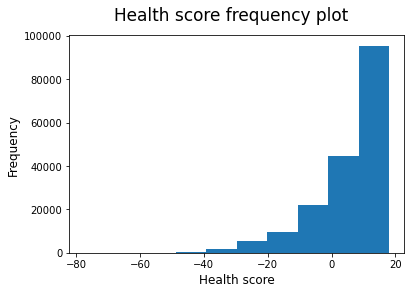

In [20]:
# distribution of "health" in the dataset
fig, ax = plt.subplots()
ax.set_xlabel('Health score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
fig.suptitle("Health score frequency plot", fontsize=17)
data_person_all["health"].hist(ax=ax)
ax.grid(False)

# Step 3: Preliminary data analysis

## Explore data house-health relation of boolian variables
In following four figures we present the relation between four house variables and health variables. The habitant of the house were quesioned whether the house is in need for a certain repair. They could either answer yes or no to these questions. Slight difference between these to groups is observed. One can see that in most of the cases house with need for a repair (blue bars) exhibit slightly lower values of health score. One has to have in mind that the distribution of health score is imbalanced across the population since most of the population is healthy so even a slight difference in health score could be important. In further analysis we will try to answer whether this difference is statisticaly significant. Interestignly it seems that people in badly maintaned houses seems to be less depressed and nervous.

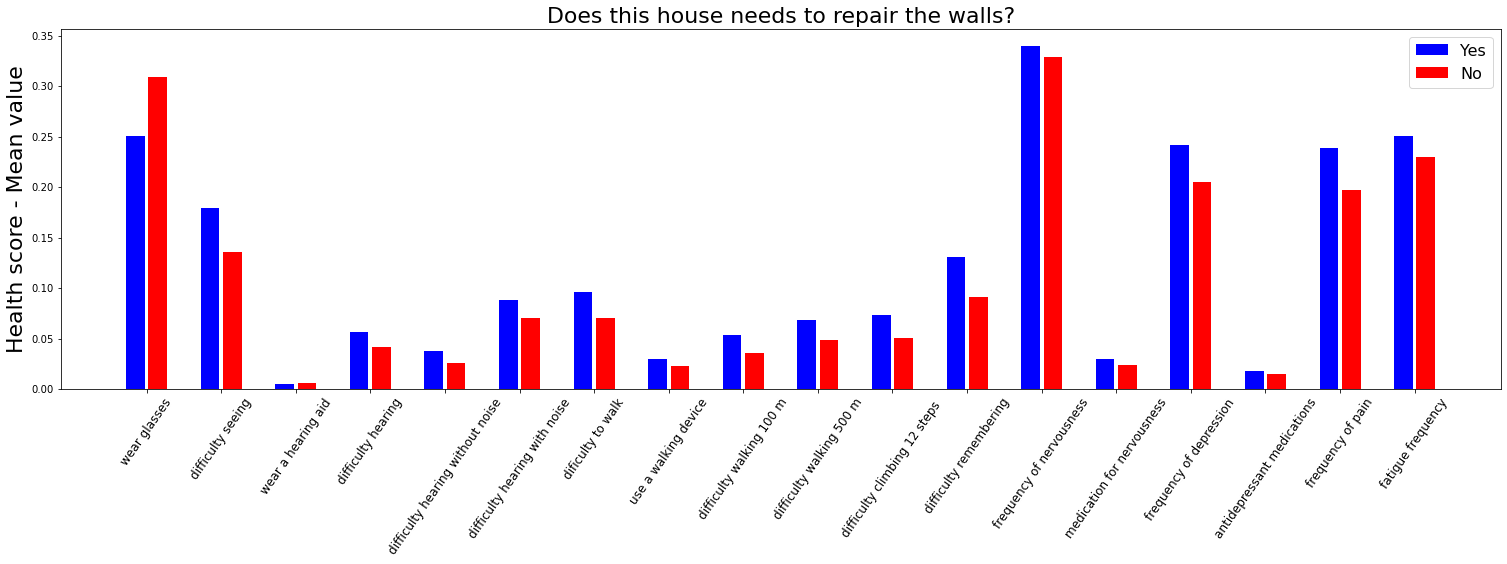

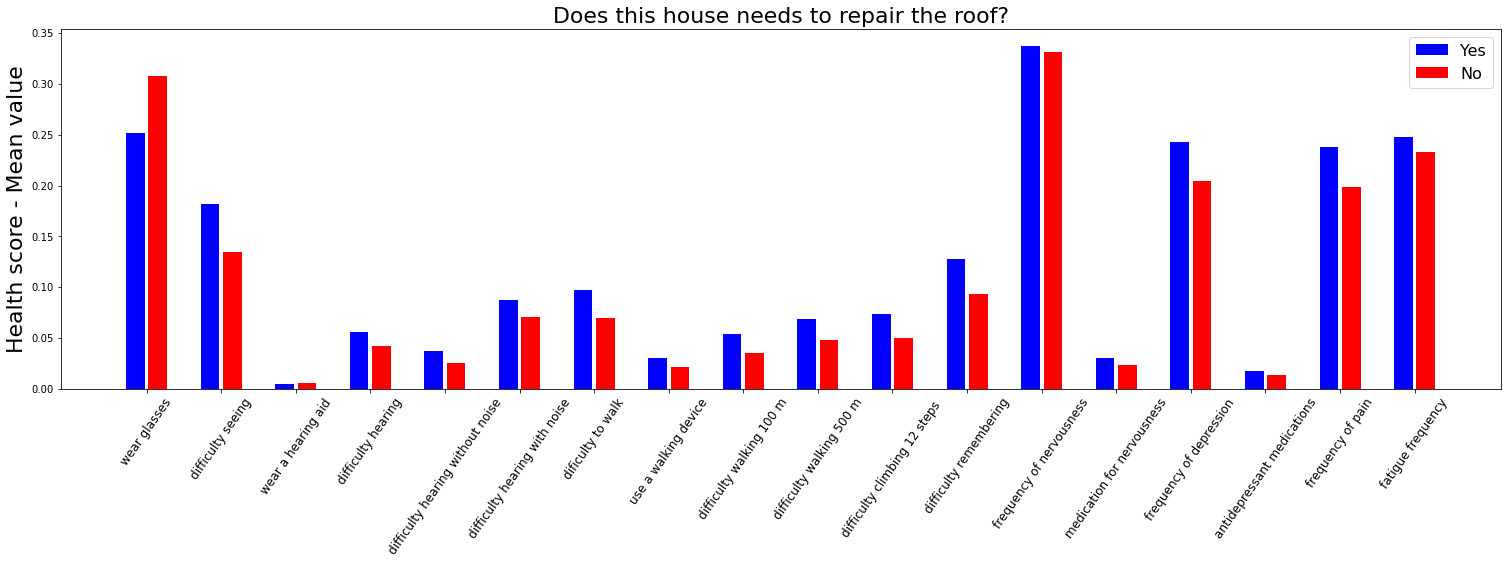

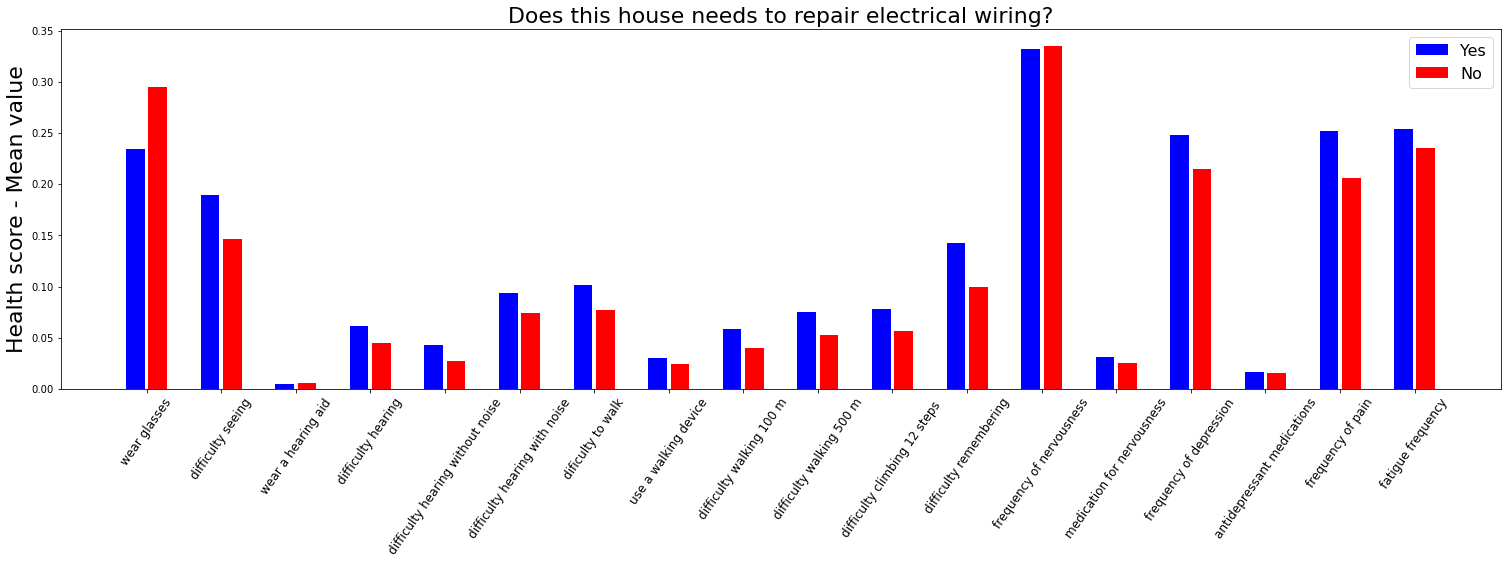

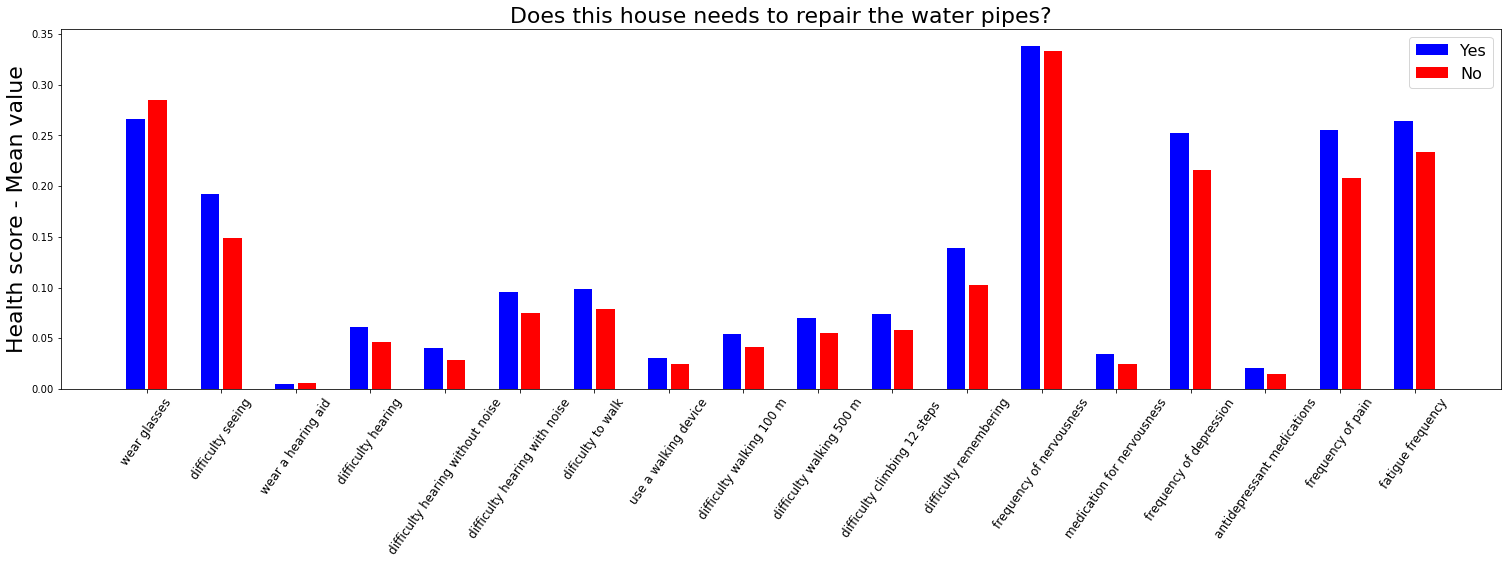

In [22]:
important_house_var=['repair_the_walls' , 'repair_the_roof' ,'repair_electrical_wiring' ,'repair_the_water_pipes']
health_var_txt=[x.replace('_',' ') for x in health_var ]

for house_item in important_house_var:
    mask=data_person_all[house_item]==1
    data_yes=data_person_all[mask]
    data_no=data_person_all[~mask]

    datay=data_yes[health_var].mean().values
    datax=data_no[health_var].mean().values

    fig = plt.figure(figsize=(20,5))
    ax = fig.add_axes([0,0,1,1])
    
    x = np.arange(len(health_var))  # the label locations
    width = 0.3  # the width of the bars

    for item in health_var:
        ax.bar(x - width/2, datay, color = 'b', width = 0.25)
        ax.bar(x + width/2, datax, color = 'r', width = 0.25)
        ax.set_xticks(x)
        ax.set_xticklabels(health_var_txt,rotation='55',fontsize=12)
        ax.legend(labels=['Yes', 'No'],fontsize=16)
    plt.title('Does this house needs to '+house_item.replace('_',' ').lower()+'?',fontsize=22)
    plt.ylabel('Health score - Mean value',fontsize=22)

    

## Building materials vs Health

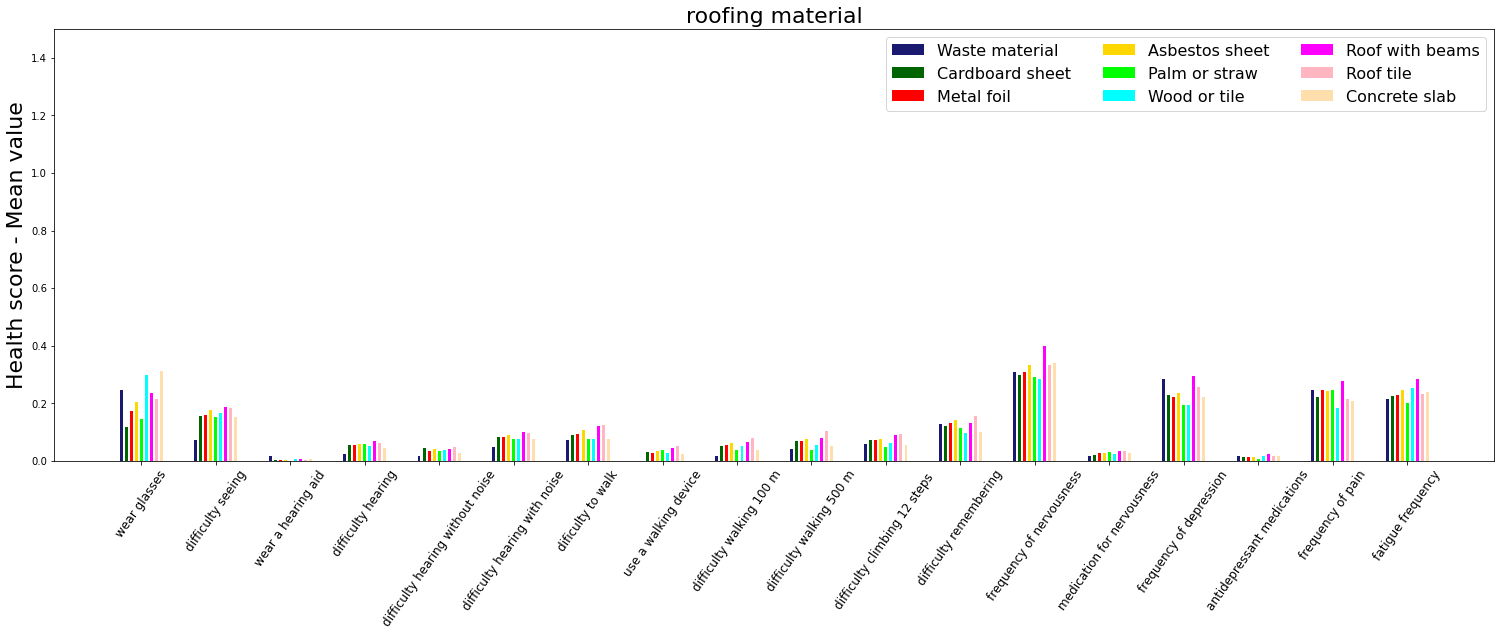

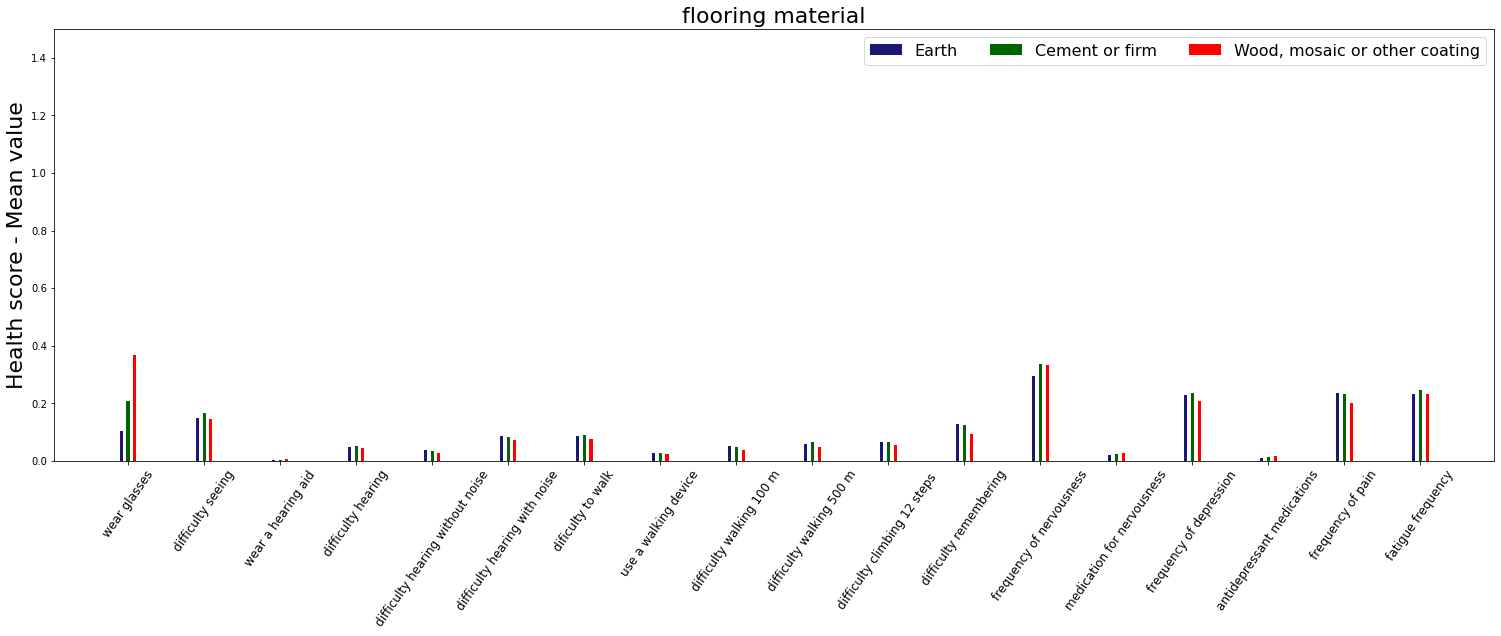

In [24]:
house_material=['roofing_material','flooring_material']
mat = [None] *2
mat[0]=['Waste material' ,'Cardboard sheet' ,'Metal foil','Asbestos sheet' ,'Palm or straw' ,'Wood or tile ','Roof with beams', 'Roof tile', 'Concrete slab' ]
mat[1]=['Earth', 'Cement or firm', 'Wood, mosaic or other coating']

for index_global,house_item in enumerate(house_material):
    answers=sorted(data_person_all[house_item].value_counts().index)
    len_answers=num=len(answers)
    
    data = [None] * len_answers
    for index,item in enumerate(answers):
        data[index]=data_person_all[data_person_all[house_item]==answers[index]][health_var].mean()
    fig = plt.figure(figsize=(20,6))
    ax = fig.add_axes([0,0,1,1])
    
    x = np.arange(len(health_var))  # the label locations
    width = 0.06  # the width of the bars
    width_vector=np.linspace(start=-width*len_answers/2, stop=width*len_answers/2,num=len_answers )
    color_list=['#191970', '#006400', '#ff0000', '#ffd700', '#00ff00' ,'#00ffff','#ff00ff' ,'#ffb6c1','#ffdead']
    
    for item in health_var:
        for index,wid in enumerate(width_vector):
            ax.bar(x + wid, data[index], width = 0.04,color=color_list[index])
        ax.set_xticks(x)
        ax.set_xticklabels(health_var_txt,rotation='55',fontsize=12)
        ax.legend(labels=mat[index_global],fontsize=16,ncol=3)
    plt.ylim(0,1.5)
    plt.title(house_item.replace('_',' '),fontsize=22)
    plt.ylabel('Health score - Mean value',fontsize=22)


## Age of house vs health

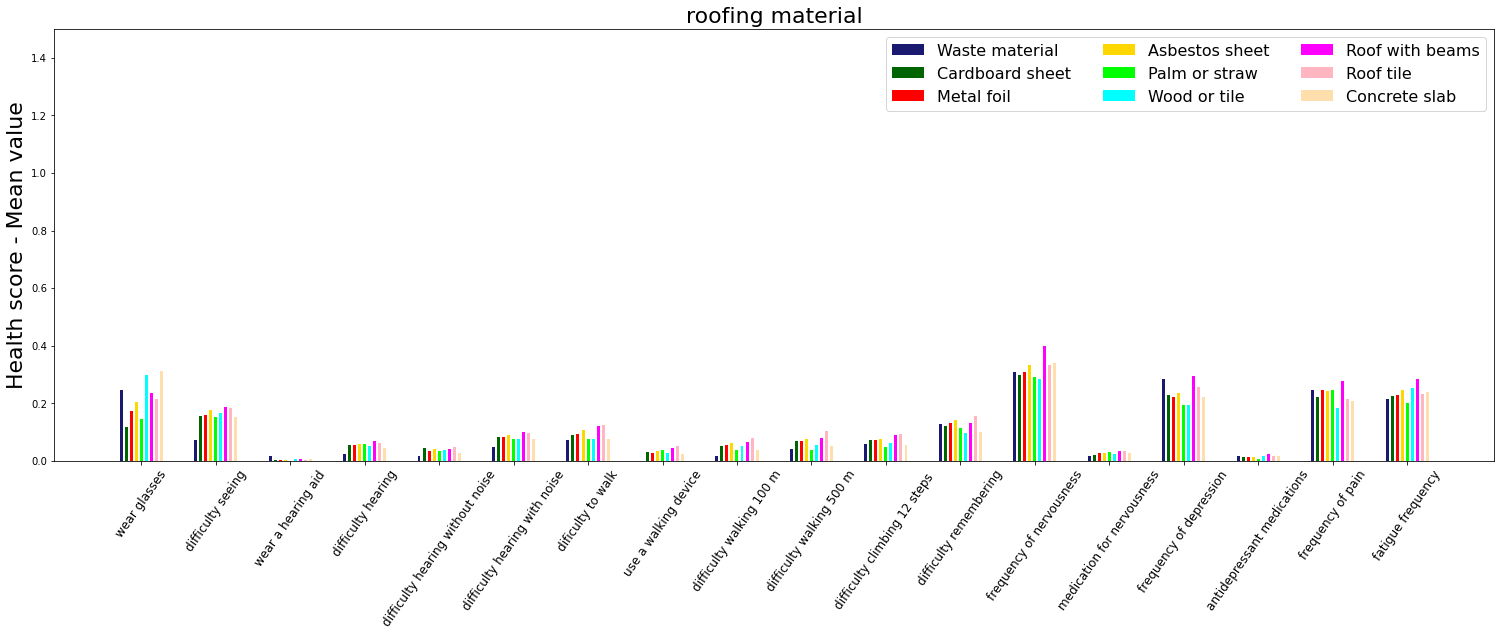

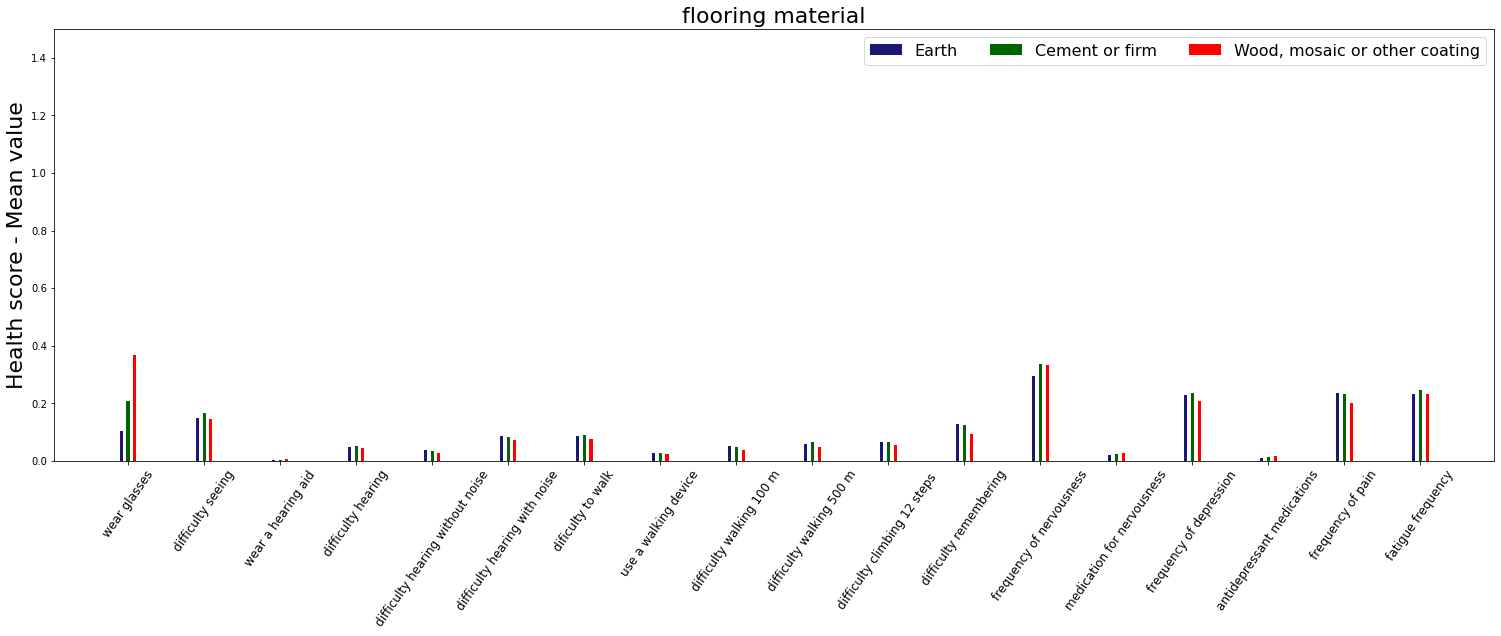

In [31]:
house_material=['roofing_material','flooring_material']
mat = [None] *2
mat[0]=['Waste material' ,'Cardboard sheet' ,'Metal foil','Asbestos sheet' ,'Palm or straw' ,'Wood or tile ','Roof with beams', 'Roof tile', 'Concrete slab' ]
mat[1]=['Earth', 'Cement or firm', 'Wood, mosaic or other coating']

for index_global,house_item in enumerate(house_material):
    answers=sorted(data_person_all[house_item].value_counts().index)
    len_answers=num=len(answers)
    
    data = [None] * len_answers
    for index,item in enumerate(answers):
        data[index]=data_person_all[data_person_all[house_item]==answers[index]][health_var].mean()
    fig = plt.figure(figsize=(20,6))
    ax = fig.add_axes([0,0,1,1])
    
    x = np.arange(len(health_var))  # the label locations
    width = 0.06  # the width of the bars
    width_vector=np.linspace(start=-width*len_answers/2, stop=width*len_answers/2,num=len_answers )
    color_list=['#191970', '#006400', '#ff0000', '#ffd700', '#00ff00' ,'#00ffff','#ff00ff' ,'#ffb6c1','#ffdead']
    
    for item in health_var:
        for index,wid in enumerate(width_vector):
            ax.bar(x + wid, data[index], width = 0.04,color=color_list[index])
        ax.set_xticks(x)
        ax.set_xticklabels(health_var_txt,rotation='55',fontsize=12)
        ax.legend(labels=mat[index_global],fontsize=16,ncol=3)
    plt.ylim(0,1.5)
    plt.title(house_item.replace('_',' '),fontsize=22)
    plt.ylabel('Health score - Mean value',fontsize=22)

## Cell phone availability vs health

Text(0, 0.5, 'Health score - Mean value')

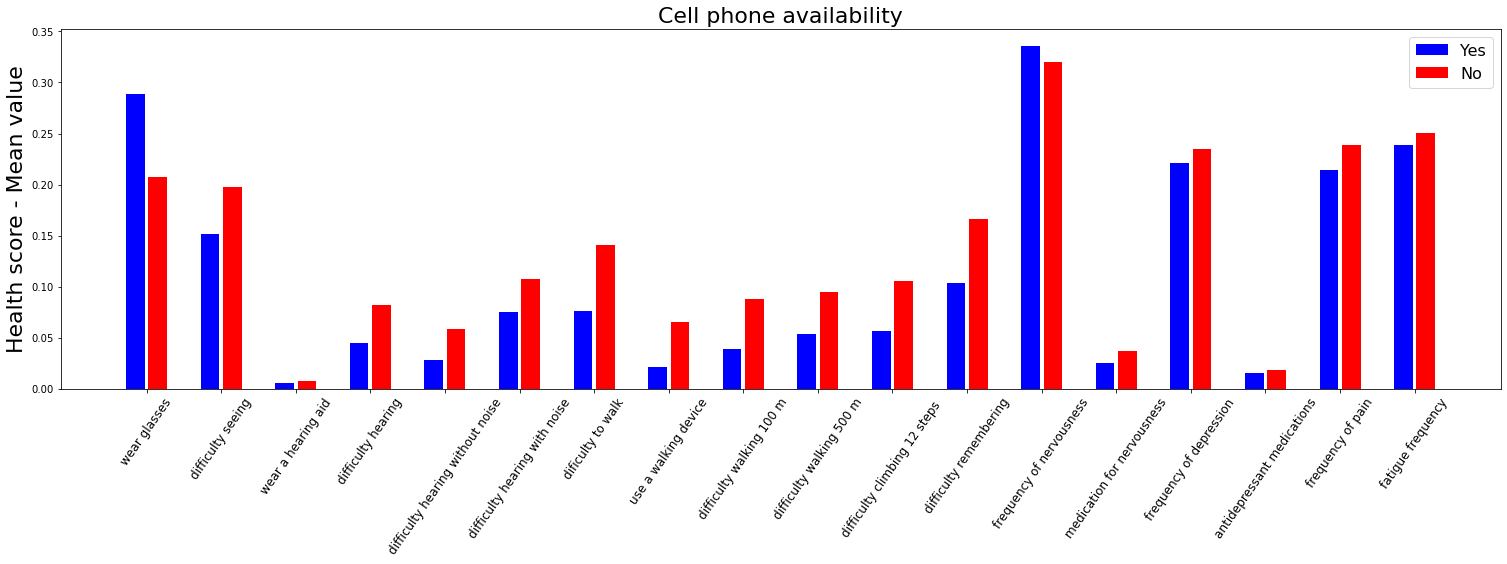

In [32]:
mask=data_person_all['cell_phone_availability']==1
data_yes=data_person_all[mask]
data_no=data_person_all[~mask]

datay=data_yes[health_var].mean().values
datax=data_no[health_var].mean().values

fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])
    
x = np.arange(len(health_var))  # the label locations
width = 0.3  # the width of the bars

for item in health_var:
        ax.bar(x - width/2, datay, color = 'b', width = 0.25)
        ax.bar(x + width/2, datax, color = 'r', width = 0.25)
        ax.set_xticks(x)
        ax.set_xticklabels(health_var_txt,rotation='55',fontsize=12)
        ax.legend(labels=['Yes', 'No'],fontsize=16)
plt.title('Cell phone availability',fontsize=22)
plt.ylabel('Health score - Mean value',fontsize=22)

## Age of person vs health

Text(0, 0.5, 'Total health score - Mean ')

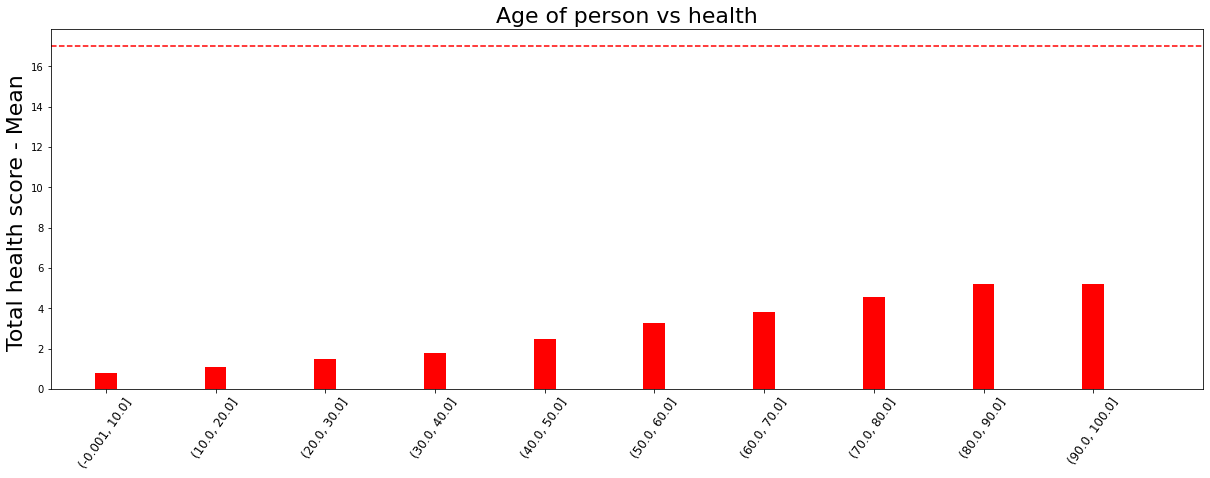

In [34]:
data_person_all['age_cat']=pd.cut(data_person_all['age'], bins=[0,10,20,30,40,50,60,70,80,90,100], include_lowest=True)
answers=sorted(data_person_all['age_cat'].value_counts().index)
len_answers=len(answers)
means = [None] *len_answers
for index,item in enumerate(answers):
    means[index]=data_person_all[data_person_all['age_cat']==item].apply(lambda x: sum([x[i] for i in health_var]), axis=1).mean()

fig= plt.figure(figsize=(16,5))
ax = fig.add_axes([0,0,1,1])    
x = np.arange(len_answers)  # the label locations
width = 0.3  # the width of the bars

ax.bar(x, means, color = 'r', width = 0.2)
plt.hlines(17,-0.5,10,linestyle = '--',color='r')
plt.xlim(-0.5,10)
ax.set_xticks(x)
ax.set_xticklabels(answers,rotation='55',fontsize=12)

plt.title('Age of person vs health',fontsize=22)
plt.ylabel('Total health score - Mean ',fontsize=22)


# Step 4: Linear Regression

### Fill response variables

In [35]:
data_person_all["health"].describe()

count    179072.000000
mean          6.677714
std          12.053653
min         -77.313462
25%           1.333333
50%          11.227584
75%          18.000000
max          18.000000
Name: health, dtype: float64

In [36]:
# To run for all health_var or for health score
response='health'

### Pearson correlation
In order to limit the number of analyzed variables and to select the most important features, we calculate Person correlation coefficient. 

In [37]:
health_var.append('health')
covariates=list(data_person_all.columns)
covariates = [x for x in covariates if not x in health_var]

In [38]:
pearson_result=data_person_all[covariates].corrwith(data_person_all['health'], axis=0, method='pearson')
pearson_result=pearson_result.reindex(pearson_result.abs().sort_values(ascending=False).index)
#for val in pearson_result.items():
    #print(val)
covariates_top=pearson_result.index[0:25];

### Fill model with all variables

In [40]:
model='~'
cat_list=['Relationship','Type_of_home_ownership', 'Flooring_material', 'Roofing_material', 'Socioeconomic' ,'Location_size', 'Fuel_type']

for index,item in enumerate(covariates_top):
    if item not in data_housing.columns:
        continue
    if index<1:
        model=model+item
    else:
        if data_person_all[item].value_counts().count()==2 or item in cat_list:
            model=model+'+'+'C('+item+')'
        else:
            model=model+'+'+item
            # Standardize the countinuous variables
            data_person_all[item] = (data_person_all[item] - data_person_all[item].mean())/data_person_all[item].std()
                
model

'~+C(repair_the_walls)+C(repair_the_roof)+C(cell_phone_availability)+C(repair_the_water_pipes)+type_of_home_ownership+C(fixed_telephone_line_availability)+C(repair_electrical_wiring)+bedroom_rooms+C(repair_drain_pipes)+C(it_has_a_gas_heater_for_water)+C(build_bedroom)+C(it_has_a_pool_or_tank)+C(it_has_a_water_tank)+C(availability_of_own_car)+C(computer_availability)+C(build_business)+C(it_has_a_light_meter)+primary_sampling_unit'

In [41]:
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(1950)
mod= smf.ols(formula=response+model, data=data_person_all,missing='raise')
res = mod.fit()
res.summary();

In [42]:
# feature names
variables = res.params.index

# quantifying uncertainty!

# coefficients
coefficients = res.params.values

# p-values
p_values = res.pvalues

# standard errors
standard_errors = res.bse.values

In [43]:
#sort them all by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

# in this case, we index starting from the first element, not to plot the intercept

# we will use standard errors, instead of CIs
# two standard errors approximate the CIs (you can actually see in the summary table that
# +/2 SI is equivalent to the CIs)

# Edit l2
l2=[x.replace('_',' ') for x in l2 ]

## Regression resluts
We plot the resulsting coefficents with intervals showing +-2 standard errors. The coefficent are sorted in the descending order.

Text(0.5, 0, 'Regression coefficent')

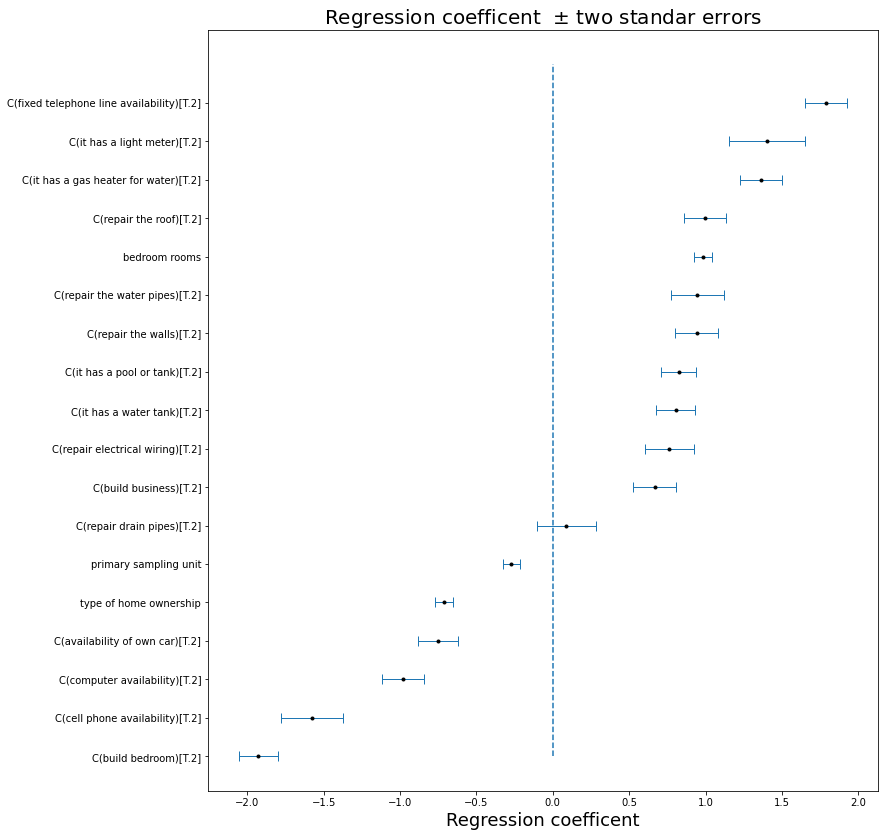

In [44]:
# Plotting
plt.figure(figsize=(12,14))
plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2);
plt.title('Regression coefficent  $\pm$ two standar errors',fontsize=20)
plt.xlabel('Regression coefficent',fontsize=18)